In [1]:
from collections import defaultdict, Counter
from itertools import chain
import json
import os.path
import zlib

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import pandas as pd

import numba as nb
from imageio import imread
from skimage.filters.rank import entropy

In [2]:
folder_lookup = "/home/bhornung/Documents/flags/data/clean-data"
folder_png = "/home/bhornung/Documents/flags/data/clean-data/images/ppm"
folder_svg = "/home/bhornung/Documents/flags/data/clean-data/images/svg"

In [3]:
# TO SKIP -- DETAILS
def get_colours_from_cmap(cmap_name, n):
    """Returns a sequence of colours from a colourmap"""
    
    cmap = plt.get_cmap(cmap_name)
    idcs = np.linspace(0, 1, num=n)
    colours = [cmap(i) for i in idcs]
    
    return colours

In [4]:
# TO SKIP -- DETAILS
class CountryPlotter:
    
    def __init__(self, data, key, ax, title):
        
        x, y = zip(*sorted(data.items(), key=lambda x: x[1]))
        self.ref_series = {"key": key, "x": x, "y": y}
        self.ax = ax
        self._lines = []
        
        self.ax.set_title(title, y=1.15, fontsize=14)
        
    def plot_reference(self, **kwargs):
        
        ax = self.ax
        x = self.ref_series["x"]
        y = self.ref_series["y"]
        n_data = len(x)
        
        # plot reference
        ln = ax.plot(x, y,
            color="navy", markersize=3, marker="o", lw=1, ls="-",
            label=self.ref_series["key"]
        )
        self._lines = ln

        # decoration
        ax.set_xlim((-1, n_data));
        ax.set_xlabel("countries", fontdict={"size": 16});
        
        ylim= kwargs.get("ylim", (min(y) * 0.8, max(y) * 1.2))
        ax.set_ylim(ylim)
        
        ylabel = kwargs.get("ylabel", "complexity / a.u.")
        ax.set_ylabel(ylabel, fontdict={"size": 14})
        
        yscale = kwargs.get("yscale", "linear")
        ax.set_yscale(yscale)
        
        # decoration++
        for i, tl in enumerate(ax.get_xticklabels()):
            tl.set_position((0, [0, 1.08, -0.05, 1.13][i % 4]))
            tl.set_weight(["normal", "bold"][i % 4 == 0])

        for i in range(0, n_data, 4):
            ax.axvline(i, ls="-", lw=1.0, color="grey")
        for i in range(2, n_data, 4):
            ax.axvline(i, ls=":", lw=1, color="grey")

        _ = [ax.axhline(y, lw=1.0, color="grey", ls="--") for y in ax.get_yticks()]
        
        ax.legend(loc="upper left")
        
    def shade_plot(self, regions, cmap="winter"):
        """Shades between vertical entries"""
        
        n_regions = len(regions)
        colours = get_colours_from_cmap("winter", n_regions)
        
        for region, colour in zip(regions, colours):
            i1 = self.ref_series["x"].index(region[0])
            i2 = self.ref_series["x"].index(region[1])
            
            self.ax.axvspan(i1, i2, color=colour, alpha=0.25)
            
    def add_series(self, data, key, colour="blue", **kwargs):
        """Adds a new series."""
        
        # get keys from reference <== data must be a superset of reference
        y = [data[k] for k in self.ref_series["x"]]
        
        # x positions are the same as those of the reference one
        x = np.arange(len(y))
        ln = ax.plot(x, y,
            color=colour, markersize=3, marker="o", lw=1, ls="-",
            label=key
        )   
        self._lines += ln

        # decoration
        self._reset_ylim(y)
        self._set_legend()
        
    def add_series_on_new_axis(self, data, key, colour="cornflowerblue", **kwargs):
        """Adds a new series on a new axis"""
        
        y = [data[k] for k in self.ref_series["x"]]
        x = np.arange(len(y))
        
        ax1 = ax.twinx()
        ln = ax1.plot(x, y,
            color=colour, markersize=3, marker="o", lw=1, ls="-",
            label=key
        )   
        self._lines += ln
        
        yscale = kwargs.get("yscale", "linear")
        ax1.set_yscale(yscale)
        
        # decoration
        self._set_legend()
        
        return ax1
    
    def _set_legend(self):
        
        labels = [l.get_label() for l in self._lines]
        self.ax.legend(self._lines, labels, loc="upper left")
    
    def _reset_ylim(self, y):
        
        ymin, ymax = self.ax.get_ylim()
        ymax = max(ymax, max(y)) * 1.2
        ymin = min(ymin, min(y)) * 0.8

        self.ax.set_ylim((ymin, ymax))

## Introduction

The complexity of flags is assesed in this blog post. The various notions of being complex are discussed which are then applied to our topic of interest, namely the flags of countries around the world.

### Data

We will use both raster images `png` and vector graphics `svg`. These were obtained and processed as follows.

#### Scalable vector graphics

The `svg` images were obtained from the respective wikipedia sites.

#### Portable network graphics

`pdf` images were downloaded from [https://flagpedia.net/](https://flagpedia.net/download). They were scaled to have a uniform width of 1,700 pixels with `PyPDF2`. This resolution is sufficent to keep the details of the intricate flags. The `pdf` images were converted to `png`-s using `pdftoppm`. It is important to disable anitaliasing to avoid colour interpolation.

### Notation

Let the set of all colours denoted by $\mathcal{C}$:

$$
    \emptyset \neq \mathcal{C} \subset \mathbb{R}^{3} \, .
$$

A flag, $F$ is an ordered tuple of colours, or, if you will, a two-dimensional sequence of pixels:

$$
    F \in \mathcal{C}^{N\times M} \, .
$$

The flags are indexed by $i$. The $i$-th flag has a height of $n_{h,i}$ and width of $n_{w,i}$:

$$
    F_{i} \in \mathcal{C}^{n_{h,i} \times n_{w,i}} \, .
$$

The $k,l$-th pixel of the flag is denoted by $p_{i,kl} \in \mathcal{C}$. For sake of brevity the flag index $i$ is sometimes dropped.

### Coding

As usual, only the relevant snippets of code are shared in this blog post. The raw notebook can be found [here](https://github.com/bhornung/bhornung.github.io/blob/master/assets/flags-4/notebook/flags-4.json).

## Setup

### Country codes

The two letter country codes will be used throughout this post. A lookup table can be found [here](https://github.com/bhornung/bhornung.github.io/blob/master/assets/flags-4/data/iso-country.json).

In [5]:
with open(os.path.join(folder_lookup, "iso-country.json"), "r") as fp:
    ccodes = json.load(fp)

### Loading images

It is preferable not to keep huge amount of data in the memory all the time. This is achieved by the flags being sequentially loaded before each run of calculations. `create_image_loader` yields a loader on request.

In [6]:
def create_image_loader(folder, func, tokens, ext):
    """Creates a generator of generator of images."""
    while True:
        gen_path = ((x, os.path.join(folder, f"{x}.{ext}")) for x in tokens)
        generator = ((k, func(v)) for k, v in gen_path)
        yield generator

We are going to use `png` images extensively in the post most often, so a loader object is created.

In [7]:
image_loader = create_image_loader(folder_png, imread, ccodes.keys(), "png")

### Encoding images

Oftentimes it only matters whether two colours are identical or not. Therefore each colour is assigned a single byte identifier in these cases. This is achived by the `label_encode_image` utility.

In [8]:
def label_encode_image(image):
    """Returns an array of colour indices."""

    records = np.ascontiguousarray(image)\
              .view(np.dtype((np.void,
              image.dtype.itemsize * image.shape[-1])))

    labels, idcs = np.unique(records, return_inverse=True)
    image_new = idcs.reshape(image.shape[:2]).astype(np.uint8)
    
    return image_new

### Storing results

It is neater to keep all of the results -- which will be of type `{str: float}` in one place as opposed have many differently, and most likely cryptically, named dictionaries. The `complexity` dictionary is set as the central storage.

In [9]:
complexity = defaultdict(dict)

### Reading the graphs

Each country is represented by its two letter code in the complexity graphs. They are grouped in blocks of four. The first in each block printed in bodface. They are read in the following order
* bottom left
* top left
* bottom right
* top right

As an example, the first five entries from the left in the colour change density graph are: MC, ID, PL, CG, JP. That is Monaco, Indonesia, Poland, Republic of the Congo and Japan. 

## Graphical complexity

### Density of colour changes

A simple way of measuring the complexity of a flag is to count how many times it switches colours both in the horizontal and vertical directions. This measure depends on the size of the canvas. Number of changes needs to be divided by the canvas area to make it independent:

$$
r_{g} = \frac{1}{n_{h} \cdot n_{w}} \left[
    \sum\limits_{k=1}^{n_{h} - 1}\sum\limits_{l=1}^{n_{w}} 
    \left(1 - \delta_{p_{k, l} p_{k+1, l}} \right)
    +
    \sum\limits_{k=1}^{n_{h}}\sum\limits_{l=1}^{n_{w} -1} 
\left(1 - \delta_{p_{k, l} p_{k, l + 1}} \right) 
\right] \, .
$$

The ratio does not tell us how many colours are in a flag. It only shows how frequently the colour changes between neighbouring pixels. It is also worthy mentioning that this ratio tends to zero as the canvas size increases. The area is proportional to the square of the characteristic length, whilst the number of changes is a linear function of it. The reason we can still use it is because _i)_ all flags have the same width, _ii)_ we normalise by the height in the formula above. As a consequence, flags with higher aspect ratio of the same pattern will be marked more complex, in line with the intuition.

#### Implementation
This is implemented by two functions. `get_edges` locates the edges between different colours. `calc_colour change_ratio` calculates the ratio. In theory, it is possible (and neater) to to performs the two spets in a single function, but we will need the edges later on.

In [10]:
def get_edges(image):
    """Finds the edges of a 2D image."""
    
    image_new = np.zeros(image.shape, dtype=np.bool)

    # vertical
    edges = (image[:-1] - image[1:]) != 0
    image_new[:-1] = np.logical_or(image_new[:-1], edges)

    # horizontal
    edges = (image[:, :-1] - image[:, 1:]) != 0
    image_new[:, :-1] = np.logical_or(image_new[:, :-1], edges)
    
    return image_new.astype(np.uint8)


def calc_colour_change_density(image):
    """Calculate the ratio pixelwise colour changes
    wrt the total number of pixels."""
    
    n_h, n_w = image.shape[:2]
    n_change = image.sum()

    r_g = n_change / (n_w * n_h)
    
    return r_g

#### Discussion

The colour change density is calculated for all flags in two steps.

In [11]:
encoded = ((k, label_encode_image(v)) for k, v in next(image_loader))
edges = ((k, get_edges(v)) for k, v in encoded)
complexity["col-change-density"] = {k: calc_colour_change_density(v) for k, v in edges}

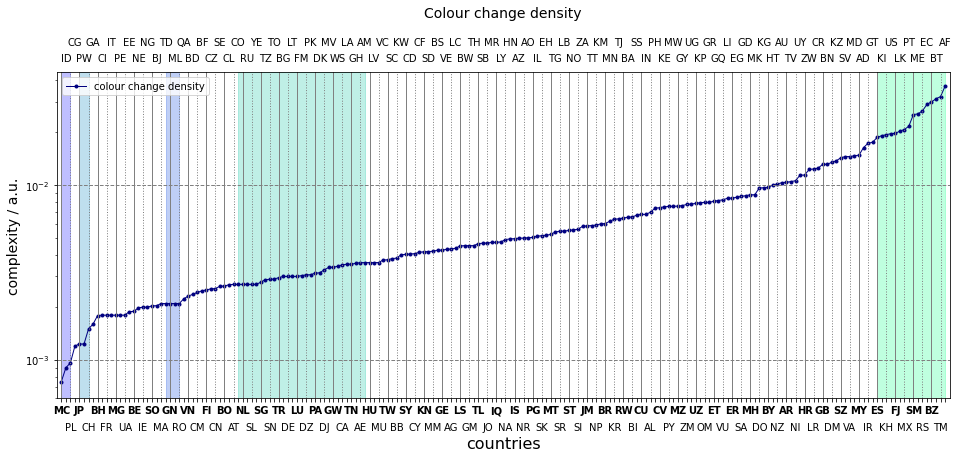

In [12]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)

plotter_dens = CountryPlotter(
    complexity["col-change-density"],
    "colour change density", ax,
    "Colour change density"
)
plotter_dens.plot_reference(yscale="log")
regions = ["MC", "PL"], ["TD", "RO"], ["JP", "CH"], ["CO", "AM"], ["ES", "AF"]
plotter_dens.shade_plot(regions, ax)

A number of groups can be distinguished.
* Countries with a single horizontal division make up the first group: Monaco (MC), Indonesia (ID), Ukraine (UA), Poland (PL). Remember, the density depends on the aspect ratio, so they wont be exatcly equal.
* The first flat section belongs to countries with three vertically aligned rectangles, such as Mali (ML), France (FR), Nigeria (NG), Guinea (GN).
* The slope afterwards mostly contains countries with a single object on a uniformly coloured background. Examples are Japan (JP), Vietnam (VN), Palau (PW).
* The sequence of plateaus is created by countries which have two horizontal divisions, but their aspect ratio differens. Russia (RU), Estonia (EE); Germany (DE), Luxembourg (LU); Hungary (HU), Armenia (AM)
* The rest of the curve cannot be easily classified, apart from the highest twenty or so entries made up from intricate flags.

This simple measure can gauge complexity to a reasonable extent. In addition, groups can be identified with its help. However it has some shortcomings which will be dicussed next.

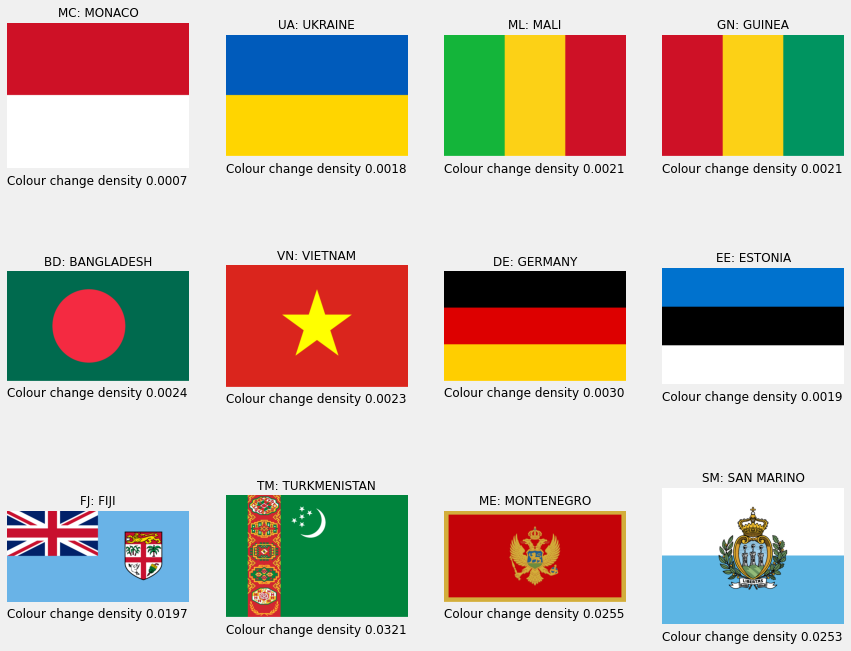

In [13]:
# TO SKIP -- PLOT SETUP
sel = ["MC", "UA", "ML", "GN", "BD", "VN", "DE", "EE", "FJ", "TM", "ME" ,"SM"]

fig, axes = plt.subplots(3, 4)
fig.set_size_inches(15, 12)

for ax, token in zip(axes.flat, sel):
    im = imread(os.path.join(folder_png, f"{token}.png"))
    ax.imshow(im)
    ax.set_title(f"{token}: {ccodes[token]}")
    ax.axis("off")
    ax.text(0, im.shape[0] + 150,
        f"Colour change density {complexity['col-change-density'][token]:4.4f}",
        fontsize=12
    )
fig.set_facecolor("#f0f0f0")

### Note on the number of edges

The flags of Burkina Faso (BF) and Gabon (GA) their complexities are nearly equal, 0.0204, an 0.0208, respectively. One might argue that, the former flag is more complex. It is composed of two rectangles and a star, as opposed to the former one made up of three rectangles. It would be possible to count the number of edges and use it to measure intricacy. Perhaps, combined with the colour change ratio. `skimage` and `opencv` have Hough detectors which would find the edges. However, implementing the edge count in a robust way would extend beyond the scope of this blog post. Just consider the flags of Japan and Turkmenistan.

## Entropic complexity

The change density only counts the pairs of pixels which had different colours. It does not account for how many different colours are present in the four-neighbourhood of a pixel. For example the _yellow, red, yellow_ horizontal sequence remains undistinguished from the _yellow, red, green_ one if only the colour changes are counted. On the other hand, more colours in a region indicate finer structures, greater complexity.

### Local entropy
Entropy, our good old friend, also registers the number of distinct colours. It is calculated from the probability distribution of colours in neighbourhood. We choose the 8-neighbourhood:

$$
\begin{eqnarray}
\mathcal{N}_{ij} & = &\{p_{i-k, j-l}, k,l \in \{-1, 0, 1 \} \} \\
P_{m} &=& \frac{\sum\limits_{k=i-1}^{i+1}\sum\limits_{j-1}^{j+1} \delta_{p_{m}, p_{kl}}}
{9} \, , \, \, \forall p_{m} \in \mathcal{N}_{ij} \\
h_{ij} &=& \sum\limits_{p_{m} \in \mathcal{N}_{ij}} - p_{m}\log_{2} p_{m} \, .
\end{eqnarray}
$$

The entropy of the entire image, $H_{i}$ is the the mean of the pixel entropies $h_{ij}$, scaled by the area:

$$
H_{i} = \frac{\sum\limits_{i=1}^{n_{h,i}} \sum\limits_{j=1}^{n_{w,i}} h_{k,l} } {n_{h,i} \cdot n_{w,i}} \, .
$$

#### Implementation

`skimage`-s `entropy` function is invoked which is thinly wrapped in the utility function of `calc_entropy`. The `label_encode_image` function below assigns a unique label to each colour transforming the image to 2D. It will be discussed later on.

In [14]:
def calc_local_entropy(image, nbh=8):
    """Calculates the entropy of a 3D image"""
    n_h, n_w = image.shape[:2]

    if nbh == 4:
        selem = np.array([[0, 1, 0], [1,1,1], [0,1,0]])
    elif nbh == 8:
        selem = np.ones((3, 3))
    else:
        raise ValueError("Only 4 8 neighbourhoods are allowed.")
    h = entropy(image, selem)
    
    h_avg = h.sum() / (n_h * n_w)

    return h_avg

#### Discussion

Again, all flags are processed sequentially. 

In [15]:
# 4-neighbourhood
encoded = ((k, label_encode_image(v)) for k, v in next(image_loader))
complexity["entropy-local-4"] = {k: calc_local_entropy(v, nbh=4) for k, v in encoded}

# 8-neighbourhood
encoded = ((k, label_encode_image(v)) for k, v in next(image_loader))
complexity["entropy-local-8"] = {k: calc_local_entropy(v, nbh=8) for k, v in encoded}

The entropy based complexities are plotted on top of that derived from the colour changes. It is striking to notice that the three series strongly correlate. Only a maximum of nine connected pixels are investigated at a time. Most frequently there are vertical or horizontal divisions between two colours. As a consequence, most of the edges in a square are due to two colours. Similary, the total probability used in the entropy calculation is distributed between two colours. It does not matter whether colour "a" has three aligned pixels and colour "b" six, or the other way around for the entropy only cares about their relative number not their actual values. As a consequence, the same entropy value will be returned for most of the squares which have more than one colours.


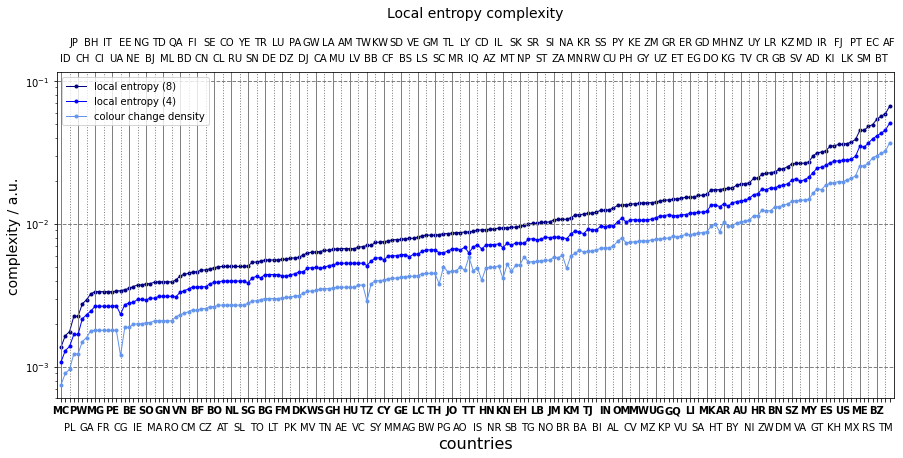

In [16]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 6)

plotter_ent = CountryPlotter(
    complexity["entropy-local-8"],
    "local entropy (8)",
    ax,
    "Local entropy complexity"
)
plotter_ent.plot_reference(yscale="log")
plotter_ent.add_series(complexity["entropy-local-4"], "local entropy (4)")
plotter_ent.add_series(
    complexity["col-change-density"], "colour change density",
    colour="cornflowerblue"
)

Entropy has a dinguishing power when flags display detailed patterns. The colours are more likely to separated along other than vertical or horizontal lines, higher chances of varied distribution. It enough to look at the contries beyond the UK. The colour density spans between 0.02 and 0.033, whereas the eight-neighbourhood entropies extend from 0.025 to 0.06.

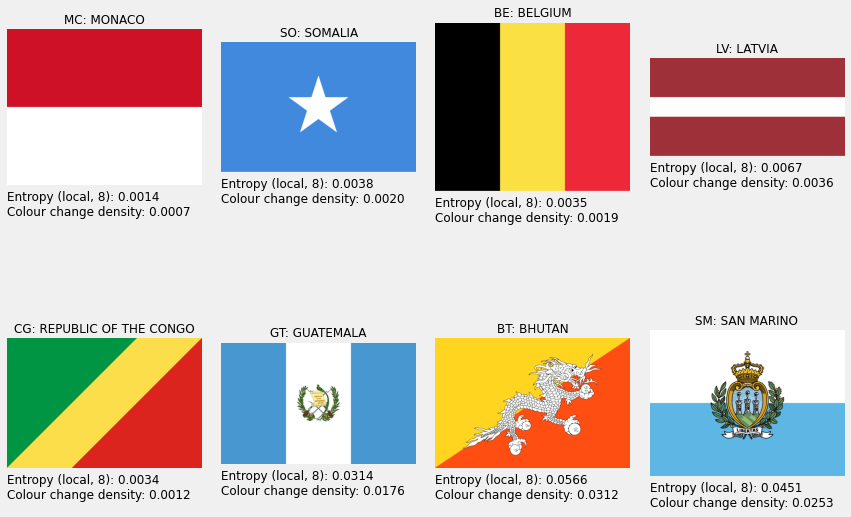

In [48]:
# TO SKIP -- PLOT SETUP
sel = ["MC", "SO", "BE" , "LV", "CG", "GT", "BT", "SM"]

fig, axes = plt.subplots(2, 4, gridspec_kw={"wspace": 0.1})
fig.set_size_inches(15, 10)

for ax, token in zip(axes.flat, sel):

    im = imread(os.path.join(folder_png, f"{token}.png"))
    ax.imshow(im)
    ax.axis("off");
    ax.set_title(f"{token}: {ccodes[token]}")
    ax.text(0, im.shape[0] + 260,
        f"Entropy (local, 8): {complexity['entropy-local-8'][token]:4.4f}\n" +
        f"Colour change density: {complexity['col-change-density'][token]:4.4f}",
        fontsize=12
    )
fig.set_facecolor("#f0f0f0")

Obviously, the entropy depends on the area in which it is calculated. The $H_{8}$ values are constantly above $H_{4}$ series. The larger the area the more colours can appear in it. What happens if the area is as large as the image itself?

### Global entropy

The answer is that one retrieves the [colour histogram entropies](https://bhornung.github.io/python/2020/08/12/flags-3.html). They tell very little about how the colours spatially distributed are. A more interesting consideration that the local entropy is insensitive to the values the colours. It only detects whether adjacent pixels are of the same colour or not.

Imagine a tripartite flag where the left one third is a checker of, say, yellow and black. The middle section is constant black, and the right is again a checker of yellow and black. Let us calculate the entropy. We then swap the yellow pixels to red ones in the right panel. If we calculate the entropy again, we will find that the two values are equal. Nevertheless, the second flag is perceived as more complicated.

Let us assume there is a flag of size $n_{h}, n_{w}$. It has $n$ colours. If $n \ll n_{h} \cdot n_{w}$, and the the colours $\{c_{i}\ i \in \left[1, ..., n \right] \}$ are randomly distributed, then the probability that two colours are adjacent is:
$$
P(c_{i}, c_{j})=\frac{1}{\binom{n}{2}} \, , \,\, \forall i,j
$$

The associated entropy is:
$$
H_{g, max} =  - \sum\limits_{i=1}^{n}\sum\limits_{j=i}^{n} P(c_{i}, c_{j}) \log_{2}P(c_{i}, c_{j}) \, .
= \log_{2} \left( n \cdot (n - 1) \right)
$$

This has the desirable property that it bounds from above all entropies which are calculated from fewer colours. As such, it measures two properties simultaneously, _i)_ the number of colours, _ii)_ their spatial distribution.

We therefore introducte the "global entropy", $H_{g}$ as a measure of complexity. It is counted how many times each possible colour pair appears in a flag. A probability distribution is formed from which the entropy is calculated. 

$$
H_{g} =  - \sum\limits_{i=1}^{n}\sum\limits_{j=i}^{n} \left(1 - \delta_{c_{i}, c_{j}} \right)
    P(c_{i}, c_{j}) \log_{2}P(c_{i}, c_{j}) \, .
= \log_{2} \left( n \cdot (n - 1) \right)
$$

#### Implementation

All horizontal and vertical pairs are counted sequentially over the views of the encoded image array. The counts where the first and the second indices are swapped then merged together to avoid double counting pairings.

In [18]:
def calc_prob_distribution(image):
    """Calculates adjacent pixel colour pmf."""

    # all pixel pairs in each direction
    cnts_v = Counter(zip(np.ravel(image[:, 1:]), np.ravel(image[:, -1])))
    cnts_h = Counter(zip(np.ravel(image[1:]), np.ravel(image[:-1])))
    cnts = cnts_h + cnts_v

    # merge duplicates
    counter = defaultdict(int)
    for k, v in cnts.items():
        counter[tuple(sorted(k))] += v

    # keep counts, transform to pmf
    p = np.array(list(counter.values()))
    p = p / p.sum()
    
    return p


def calc_global_entropy(image):
    """Calculates adjacent pixel colour entropy."""

    p = calc_prob_distribution(image)
    h = - np.dot(p, np.log2(p))
    
    return h

#### Dicsussion

The results are added to our central store in one sweep, and plotted as usual.

In [19]:
encoded = ((k, label_encode_image(v)) for k, v in next(image_loader))
complexity["entropy-global"] = {k: calc_global_entropy(v) for k, v in encoded}

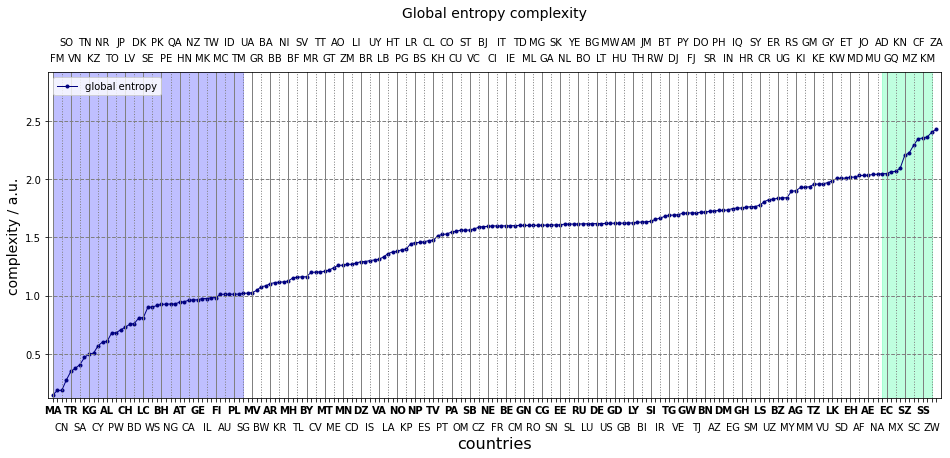

In [20]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)

plotter_entg = CountryPlotter(
    complexity["entropy-global"],
    "global entropy",
    ax,
    "Global entropy complexity"
)
plotter_entg.plot_reference()
plotter_entg.shade_plot([["MA", "SG"], ["AD", "ZW"]])

The results are rather counterintuitive. Why is the flag of Thailand (TH) more complex than that of Kazakhstan (KZ)? Or what makes the US flag simpler than the Kuwaiti (KW) one?

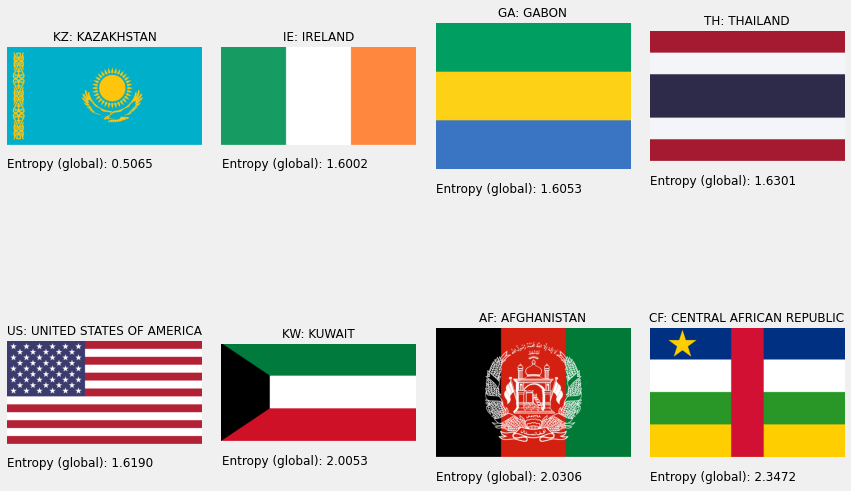

In [21]:
# TO SKIP -- PLOT SETUP
sel = ["KZ", "IE", "GA", "TH", "US", "KW", "AF", "CF"]

fig, axes = plt.subplots(2, 4, gridspec_kw={"wspace": 0.1})
fig.set_size_inches(15, 10)

for ax, token in zip(axes.flat, sel):

    im = imread(os.path.join(folder_png, f"{token}.png"))

    n_h, n_w = im.shape[:2]
    ax.imshow(im)
    
    ax.axis("off")
    ax.set_title(f"{token}: {ccodes[token]}")
    ax.text(0, im.shape[0] + 200,
        f"Entropy (global): {complexity['entropy-global'][token]:4.4f}",
    fontsize=12
    )    
fig.set_facecolor("#f0f0f0")

We made a number of really strong statements in the definitions above:
* Complexity is equivalent to randomness.
* The most random flag has infinite number of colours which are distributed totally by chance.
* The randomness can be measured by the entropy. This is, in fact, true.

What happens, is exactly what we should expect. More mixing between higher number of colours mean more randomness. The Kazakh flag has blue and yellow, the Tai is made up from blue, red, white. More colours in the latter one. Also, the boundaries between colours are longer. The Kuwaiti flag is composed of four colours which is one more than those in the US one. Albeit, the latter has longer bounaries, the number of colours -- especially that every two touches each other -- outweights it. Both the number and distribution of colours matters. 

## Compression complexity

The notion of pixel-by-pixel variability leads us to the following measure of complexity. Each colour can be indexed by an integer. The image thus can be seen as a sequence of integers.  If a sequence of a given colour and length is encoded by symbol the entire flag is transformed into a string of symbols. The more numerous and longer the subsequences of the same colour are, the shorter the final string representation is. A flag is perceived as simple if it is composed of few colours and primitive shapes. It is thus expected that the string length relates to the complexity.

The standard compression methods, such as the `DEFLATE` algorithm works along the subsequence encoding principle. It first encodes a bytestring, then creates a lookup table of codewords which are then encoded according to the table. We proceed to measure the complexity of the flags through compression.

### Implementation

It would be tempting to encode the raw bytestring that represnts the image in the memory. Each pixel corresponds to three bytes so these triplets are sequentially processed. However, this would bias the compression ratio of images having colours whose bytes are equal towards a higher value. Repeated triplets of the pattern `0xmn, 0xmn, 0xmn` are easier to encode the sequential triplets of `0xmn, 0xkl, 0xij`. On the other hand, there is no reason for a colour being treate as more complex based on its byte representation. It only matters whether two subsequent colours are identical or not. Each colour is therefore assigned a one byte long identifier to resolve this issue by `label_encode_image`.

The bytes of the encoded image are counted, then compressed. The size of the compressed bytestring is measured then the ratio of the two is formed. Strictly speaking, the compression ratio is the original size divided by the compressed one. We instead calculate the inverse compression ratio which is expected to be proportional to the complexity _i.e_ more complicated images are shrunk to a lesser extent with respect to the simpler ones.

In [22]:
def get_image_bytes(image):
    """Returns the raw bytes of an image."""
    return image.data.tobytes()


def _calc_compression_ratio(image, level):
    """Retrieves the original and compressed sizes of an image."""
    
    header_size = 1
    
    size_orig = image.nbytes
    bytestring = get_image_bytes(image)
    
    compressed = zlib.compress(bytestring, level=level)
    size_compressed = len(compressed)

    compression_ratio = size_compressed  / size_orig

    return compression_ratio


def calc_compression_ratio(image, level=9):
    
    compression_ratio_1 = _calc_compression_ratio(image, level)
    compression_ratio_2 = _calc_compression_ratio(image.T, level)
    
    compression_ratio = min([compression_ratio_1, compression_ratio_2])
    
    return compression_ratio

There is one more fine detail. Some flags have their colours oriented horizontally _e.g._ Austria, some vertically _e.g._ Peru. Both have the same perceptual complexity. If they are processed along horizontal lines, Peru's flag would show up as more complex. Each line sports three colours as opposed to one thus more codewords are then needed. To remove this effect, all flags are compressed horizontally and vertically and the smaller result is chosen.

### Discussion

A hangful of countries are selected to test this method. These are in order of perceived complexity
* simple: France, Latvia
* moderately complex: Mongolia, South Africa
* complex: Bhutan, Mexico

In [23]:
countries = ["LV", "FR", "MN", "ZA", "BT", "MX"]
flags = ((k, imread(os.path.join(folder_png, f"{k}.png"))) for k in countries)

Since the flags of different size, it is important to gauge whether complexity depends on it. The images are megapixeled across a range. The compression ratio is then calculated for each image.

In [24]:
def megapixel(image, n):
    """Megapixels an image. Creates a new object"""
    image_new = np.repeat(np.repeat(image, n, axis=0), n, axis=1)
    return image_new

In [25]:
flags = ((k, label_encode_image(v)) for k, v in flags)
compression_ratios = {k:
    [
        (n, calc_compression_ratio(megapixel(v, n)))
        for n in range(1, 9, 1)
    ] 
    for k, v in flags
}

As we can see, the compression ratio depends on the size in a varying manner. The compression ratio of France and Latvia unchanged at a value of 0.001. They trebled when the canvases of Mongolia and South Africa are eight times magnified. There is a tenfold decrease in the cases of Bhutan and Mexico.

Text(0, 0.5, 'inverse compression ratio')

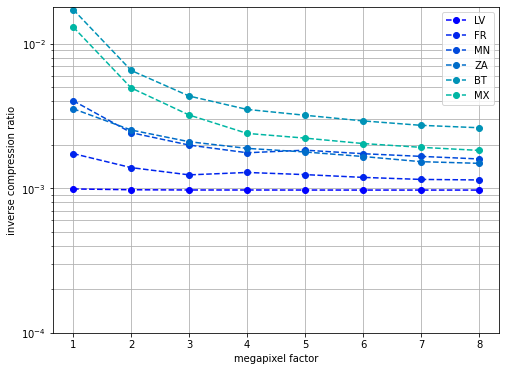

In [26]:
# TO SKIP -- PLOT SETUP
colours = get_colours_from_cmap("winter", 8)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)
for i, (k, v) in enumerate(compression_ratios.items()):
    x, y = zip(*v)
    ax.plot(x, y, label=k, ls="--", marker="o", color=colours[i])
    
ax.legend(); ax.grid(True, which="both");
ax.set_ylim(bottom=0.0001); ax.set_yscale("log")
ax.set_xlabel("megapixel factor"); ax.set_ylabel("inverse compression ratio")

If a flag is four times bigger, its areas of identical colours are four times bigger too. The sequence of bytes thus will contain more repeating patterns. The flag of Latvia already has large areas of constant bytes, thus enlarging it does not change its complexity. No new codewords are created, the already existing ones are repeated four more times. On the contrary, the Mexican canvas will be simpler if magnified. It will contain longer sequences of the same colours or bytes. These sequences are simpler to compress, thus the compression ratio will be larger.

The following little thought experiment further illustrates this concept. Let us have two flags of the same base colour, both of the size 100 by 100 pixels. One has a vertical stripe with a width of twenty pixels, the other one a vertical stripe with a width of two pixels. Both stripes start at the same position. Let us also assume that the compressor has a wondow length of 20 bytes. As the compression algorithm ingests the bytestring of the first flag, it creates a code for the twenty pixels long segment and reuses it later two cover 2/100 of the flag. As to the other flag, the window with the stripe in it needs three codes: 1) stripe, 2) rest of the window, 3) code for 1) and 2) together. Therefore the compressed file will be bigger and the compression ratio smaller. If the second flag is megnified by a factor of ten, only one code will be sufficient to store the stripe. The compressed file will thus be small with respect to the original one, thus the compression ratio is the higher. 

### Size adjusted compression complexity

How to resolve this issue? The compression ratios can be read off at large magnifications where they become practically constant. Alternatively, the ratio of the values at no and maximum magnifications reflects the complexity. The smaller it is the less sensitive the compression algorithm to the size, the simpler the flag. Both approches will be tested.

Compression ratio at the original sizes.

In [27]:
flags = ((k, label_encode_image(v)) for k, v in next(image_loader))
complexity["compression-ratio-delf-1"] =\
{k: calc_compression_ratio(v) for k, v in flags}

Compression ratio is also calculated at sixfold magnification where the compression ratios plateau off.

In [28]:
flags = ((k, label_encode_image(v)) for k, v in next(image_loader))
complexity["compression-ratio-delf-6"] =\
{k: calc_compression_ratio(megapixel(v, 6)) for k, v in flags}

Increase factor is the ratio of the two compression ratios

In [29]:
complexity["compression-incr"] =\
{k: (complexity["compression-ratio-delf-1"][k] /
     complexity["compression-ratio-delf-6"][k])
 for k in complexity["compression-ratio-delf-6"]}

The three compression complexities are shown below. The most striking features are the nearly constant initial section at a value around 0.001, and the sudden jump after it. Those flags can be found on the flat line which are composed of aligned rectangles. These can be compressed really efficiently, with very few bytes. The one thousands compression ratio is likely to due to an internally set maximum compression ratio (or some other quirks of the `zlib` implementation of `DEFLATE`). 

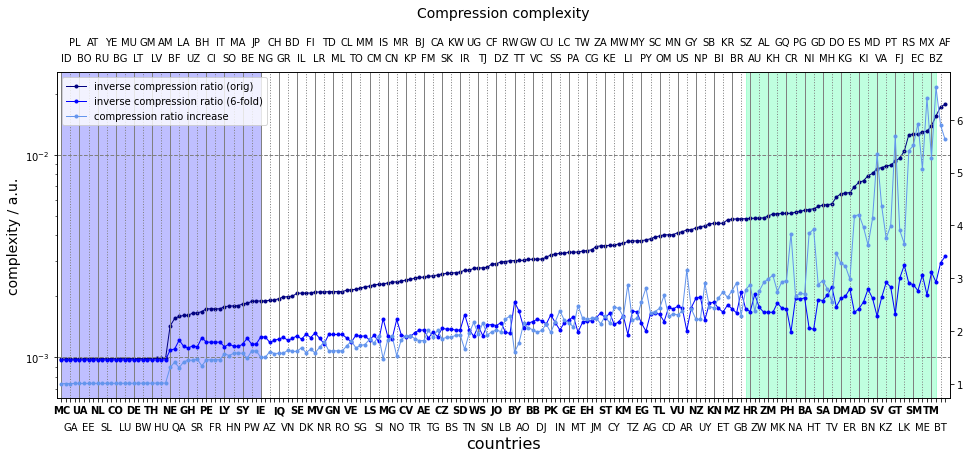

In [30]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)

plotter_comp = CountryPlotter(
    complexity["compression-ratio-delf-1"],
    "inverse compression ratio (orig)",
    ax,
    "Compression complexity"
)
plotter_comp.plot_reference(yscale="log")
plotter_comp.add_series(
    complexity["compression-ratio-delf-6"],
    "inverse compression ratio (6-fold)"
)

ax1 = plotter_comp.add_series_on_new_axis(
    complexity["compression-incr"],
    "compression ratio increase"
)

plotter_comp.shade_plot([["MC", "IE"], ["SZ", "BZ"]])

The sudden jump appears when there is a horizontal line (in the original or rotated flag) which consists of more than one colour. This breaks the constants sequence of bytes, more keywords are thus need, the compression ratio decreases our measure increases. These flags happen to be Ireland (IE) and Niger (NE).

The sixfold magnification makes the constant byte sections longer. The results is that these cancases can be compressed more efficiently, hence the jump will be smaller.

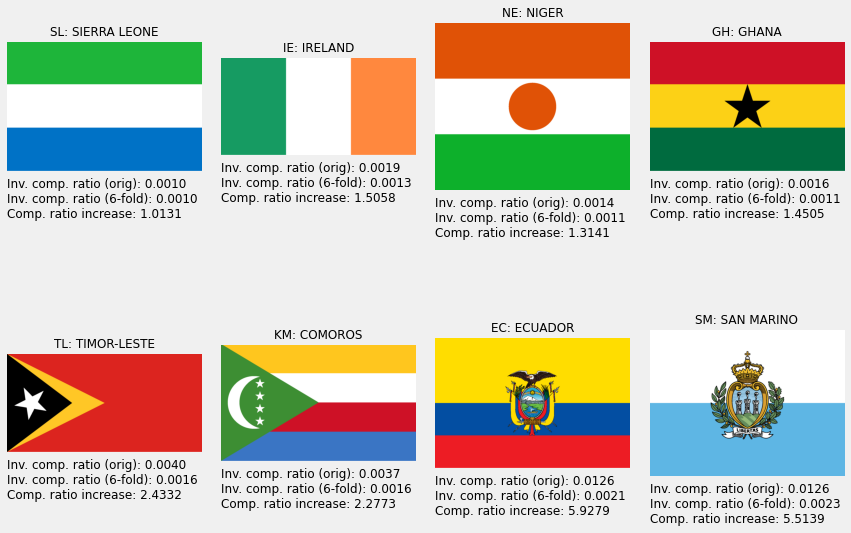

In [31]:
# TO SKIP -- PLOT SETUP
sel = ["SL", "IE", "NE", "GH", "TL", "KM", "EC", "SM"]

fig, axes = plt.subplots(2, 4, gridspec_kw={"wspace": 0.1})
fig.set_size_inches(15, 10)

for ax, token in zip(axes.flat, sel):

    im = imread(os.path.join(folder_png, f"{token}.png"))
    ax.imshow(im)
    
    ax.axis("off")
    ax.set_title(f"{token}: {ccodes[token]}")
    ax.text(0, im.shape[0] + 400,
        f"Inv. comp. ratio (orig): {complexity['compression-ratio-delf-1'][token]:4.4f}\n" +
        f"Inv. comp. ratio (6-fold): {complexity['compression-ratio-delf-6'][token]:4.4f}\n" +
        f"Comp. ratio increase: {complexity['compression-incr'][token]:4.4f}",
        fontsize=12
    )
fig.set_facecolor("#f0f0f0")

The middle section of the series consists of flags whose canvases are partitioned to increasingly larger segments of different colours. The steep last part of the line collects the usual perceptually complicated set of flags. It is worth pointing out that the three compression ratio based measures strongly correlate. It is escially interesting to see that ratio of the inverse compression ratios a good indicator of complexity.

## Compression -- chain code

The`DEFLATE` method scans the image line-by-line. Despite this, it is still able to memorize some global information about an image -- as much as its 32kB buffer allows for. It certainly, cannot recognise patters which spread across larger regions, such as starts, to mention one. A natural way to extend the compression algorithm to 2D is to encode areas of uniform colours. It is possible to reconstruct a flag from the boundaries, the colours and the painting orders (z-order) of the uniform areas. In doing so, one quite naturally registers various parts of a flag from which it is composed. The more uniform areas a flag contains, the more complicated it is, the longer the code. The algorithm the encodes an image by the perimeters of its uniformly coloured areas is called chain code compression.

The complexity will be measured by the ratio of the chain code length and the encoded image size. 

### Implementation

The technical details are beyond the scope of this blog post. The main steps of our implementation of the chain code compression algorithm can enumerated as follows:

* encode the image
* label the connected components
* find borders of the connected components
* perform a topological check on borders
* calculate border length for each component
* add colour code, z-order to each border
* calculate total number of bytes per (border length, colour code, z-order) triplets
* normalise by the byte size of the encoded image

### Discussion

The usual two step process yields the inverse of the chain code compression ratio.

In [34]:
flags = ((k, label_encode_image(v)) for k, v in next(image_loader))
complexity["compression-chain"] = {k: calc_chain_code_compression(v) for k, v in flags}

 The chain code complexity is plotted along with the ones based on `DEFLATE` and colour change density. It is a trivial affair to notice `DEFLATE` outperforming the chain code by an order of margnitude. The efficiency of dictionary encoding shows the best at flags stiched together from aligned rectangles, such as Estonia (EE), Mauritius (MU) and the like. Once the flags of this type are exhausted, the three curves neatly correlate.

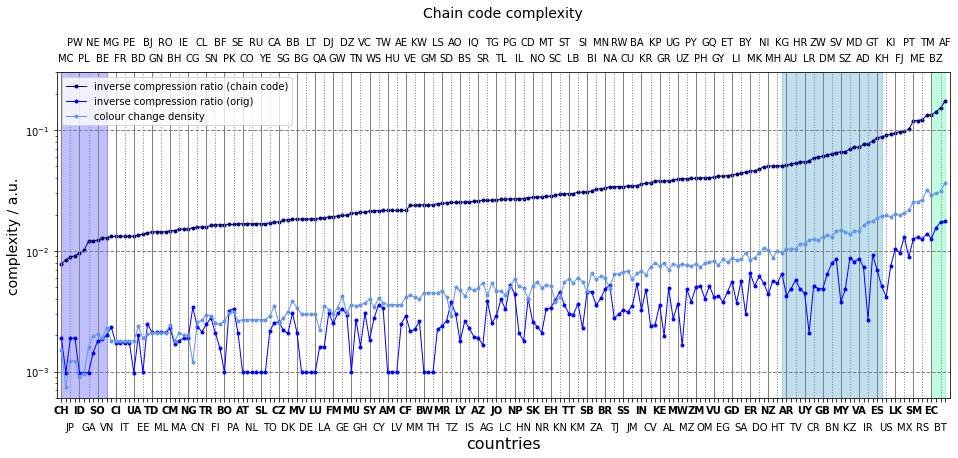

In [35]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)

plotter_comp = CountryPlotter(
    complexity["compression-chain"],
    "inverse compression ratio (chain code)", ax,
    "Chain code complexity"
)
plotter_comp.plot_reference(yscale="log")
plotter_comp.add_series(
    complexity["compression-ratio-delf-1"],
    "inverse compression ratio (orig)",
    yscale="log"
)
##
plotter_comp.add_series(
    complexity["col-change-density"],
    "colour change density", yscale="log",
    colour="cornflowerblue"
)

plotter_comp.shade_plot([["CH", "VN"], ["KG", "KH"], ["EC", "AF"]])

What is more compelling to the mind is the strong correlation between the colour change density and the chain code. The pixels where the colours change constitute the boundaries, hence the length of the chain code is almost equal to the number of colour changes, apart from the topological corrections and the additional bytes encoding the colours and the z-orders. This factor is roughly four, which it should be,

It is pleasant to see Japan, Palau, Switzerland in the same group again at the very begining of the curve. The flags composed of numerous shapes take the places in the highest fifth of the plot. 

It is somewhat wasteful to store all of the coordinates of a boundary. It would be sufficient to keep those which correspond to points where the boundary changes direction. For example, a rectangle would require only four coordinates to encode. In other words, can we just keep instructions of how to draw a flag?

## Algorithmic complexity

Complexicy manifests itself in the number of instructions with which a flag can be constructed. For instance, the set of actions to create the German flag

1. create a rectangle
1. set its dimension
1. paint it black
1. create a rectange
1. set its dimension equal to that of the first one
1. paint it red
1. place it under the first rectangle
1. create a rectangle
1. set its dimension equal to that of the first one
1. paint it gold
1. place it under the second rectangle

It is rather simple in two ways.
* simple placement and colouring operations
* simple shapes to work with.

This, algorithmic type of complexity will always depend on the set of instructions and alphabet (objects) we are working with. For example, one can create the flag of Brunei in one step:
1. create the flag of Brunei.

However, it is impossible to construct the former flag using the instructions and alphabet of the latter one. The German flag can only be obtained from the Brunei one with a rather intricate set of operations. In order to represent complexity in line with our human perception and to measure complexity in an ubiased manner across the images, one needs an uncomplicated set of instructions and alphabet. 

### Scalable vector graphics

Luckily enough, the language, `scalable vector graphics` or `svg` just fulfills these criteria. It has a set of primitives, such as strokes, simple shape, circle, rectangle, ellipse as an alphabet. These can be parametrised _e.g._ set length, width, colour etc. as instructions. It is thus plausible to assume that the complexity of the `svg` descriptions reflect that of the encoded image. 

This file format allows one for defining geometric object which are used multiple times in a file, if needed, just like a human would draw a flag. Defining more detailed object require longer set of instructions; The flag of Singapore is a prime example:

```xml
<?xml version="1.0" encoding="UTF-8"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="4320" height="2880">
<rect fill="#ed2939" width="4320" height="2880"/>
<rect fill="#fff" y="1440" width="4320" height="1440"/>  
<path fill="#fff" d="M 1481.678,720 A 541.5,541.5 0 1 1 398.67798,720 A 541.5,541.5 0 1 1 1481.678,720 z"/>
<path fill="#ed2939" d="M 1651.835,720 A 511.73499,511.73499 0 1 1 628.36499,720 A 511.73499,511.73499 0 1 1 1651.835,720 z"/>
<path fill="#fff" id="star" d="M 1007.1951,733.06439 L 933.63466,676.63425 L 860.09279,733.09117 L 888.40587,642.09687 L 814.61147,586.0053 L 905.6704,586.1981 L 933.6049,495.07467 L 961.56934,586.18798 L 1052.6282,585.96246 L 978.8522,642.0808 L 1007.1951,733.06439 z"/>
<use xlink:href="#star" transform="translate(577.18853,0)"/>
<use xlink:href="#star" transform="translate(288.88853,-214.21117)"/>
<use xlink:href="#star" transform="translate(107.99953,342.74883)"/>
<use xlink:href="#star" transform="translate(469.18853,342.74883)"/>
</svg>
```

* __line 7.__: The crescent is an intersection of two circles, as such only a few instruxtions are needed to generate it
* __line 8.__: Stars are rather complex in terms of geometry which are created using more simple objects and instructions. (As an experiment, try to describe what a cresent shape and a star shape in your chosen language and see which takes longer. That would be an indicator of complaxity.)
* __line 9--12.__: Once a star is created it is placed with a simple command. The work of recreating them is saved.

Had this flag sported four stars and three moons, it would have required more instructions to paint it, thus the `svg` instructions would have been more numerous. This is an important observation. The complexity of an image can be along the following train of logic
* if image "complex" by human perception
* more `svg` instructions are needed
* the longer the `svg` description.

One must assume that all flags are drawn at the same level of abstraction in order to be comparable. In general, this is not the case. Enough to compare a [low level](https://github.com/bhornung/bhornung.github.io/blob/master/assets/flags-4/data/usa-low-level.svg) and [high level](https://github.com/bhornung/bhornung.github.io/blob/master/assets/flags-4/data/usa-high-level.svg) decomposition of the United States flag.

We will attempt to measure the complexity of a flag through the length of its `svg` description.

### Implementation

Perhaps it was too hastily to nominate the length of the files the measure of the complexity. A propoer NLP type parser would give a more accurate answer than a character count. A feasible solution is between them can be found enumerating the shortcomings of the simpler method. The length of the object names can be arbitrary, thus carries no relevant information. The length of the coordinates is meaningless. For example, is "0.456" more complicated than "0.4". They can also be redundant "0.5" is equivalent to "0.500". A word count is more meaningful and is the way we will take. Roughly speaking a single word corresponds to a single object or instruction.

In [36]:
def read_svg_body(path):
    """Returns the contents of an svg file without the header and footer"""

    with open(path) as fp:
        lines = fp.readlines()

    return lines


def split_line(line):
    """Splits a line along whitespaces and commas."""
    words = chain.from_iterable(x.split(",") for x in line.split())
    return words


def count_svg_words(lines):
    """Counts the words in an svg file."""
    words = chain.from_iterable(split_line(x) for x in lines)
    word_count = sum(True for x in words if x)
    
    return word_count

The strings are split at whitespace or comma which separate instructions and parameters. The header and footer of a file are also ignored from the word count.

### Discussion

The svg files are processed as prescribed, and the results are plotted below.

In [37]:
svg_loader = create_image_loader(folder_svg, read_svg_body, ccodes.keys(), "svg")
complexity["algorithmic"] = {k: count_svg_words(v) for k, v in next(svg_loader)}

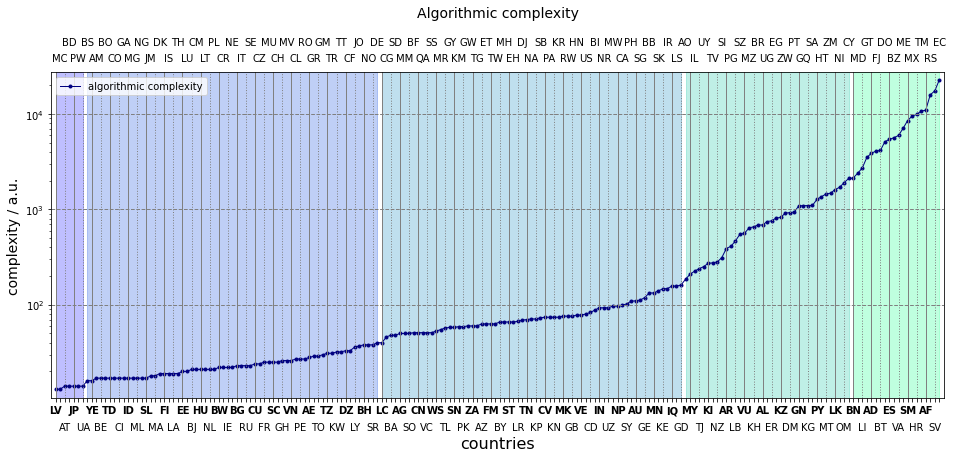

In [38]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)

plotter_comp = CountryPlotter(
    complexity["algorithmic"],
    "algorithmic complexity", ax,
    "Algorithmic complexity"
)
plotter_comp.plot_reference(yscale="log")

plotter_comp.shade_plot([["LV", "UA"], ["BS", "DE"], ["LC", "GD"], ["AO", "CY"], ["BN", "EC"]])

Of all measures, the present has the largest difference between its maximum and minimum, almost four orders of magnitude. Let us then account for each them. _Varietas delectat_, so we start from the high end. Upwards from Brunei (BN), there are large crests in the flags which need to be drawn pixel-by-pixel. The intricate crest of Ecuador (EC) is an extreme example of this. The flags down to Angola (AO) tend to have detailed drawings but of few colours. The section ending (or beginning?) with Saint Lucia sees canvases composed of numerous simple geomtrical shapes. Flags mostly containing a maximum of four shapes are between The Bahamas (BS) and Suriname (SR). The simple bicolour flags are at the very low end of the curve.

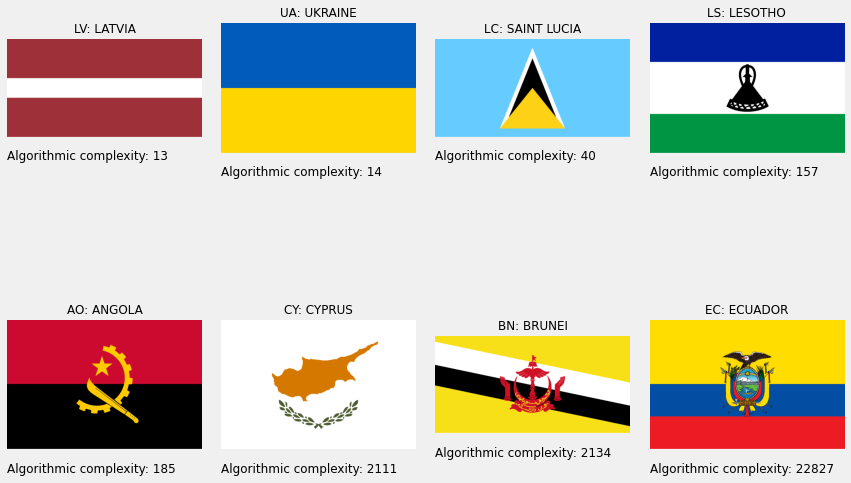

In [39]:
# TO SKIP -- PLOT SETUP
sel = ["LV", "UA", "LC", "LS", "AO", "CY", "BN", "EC"]

fig, axes = plt.subplots(2, 4, gridspec_kw={"wspace": 0.1})
fig.set_size_inches(15, 10)

for ax, token in zip(axes.flat, sel):

    im = imread(os.path.join(folder_png, f"{token}.png"))
    ax.imshow(im)
    
    ax.axis("off")
    ax.set_title(f"{token}: {ccodes[token]}")
    ax.text(0, im.shape[0] + 200,
        f"Algorithmic complexity: {int(complexity['algorithmic'][token])}",
        fontsize=12
    )
fig.set_facecolor("#f0f0f0")

## Comparison of complexities

Finally, the various flavours complexities are assessed and compared in the last section of this post. The Kendall-tau correlations are shown below. These coefficients are only sensitive to the relative ordering of items in two series, it does not require a linear relationship or exact matching of the ranks. 

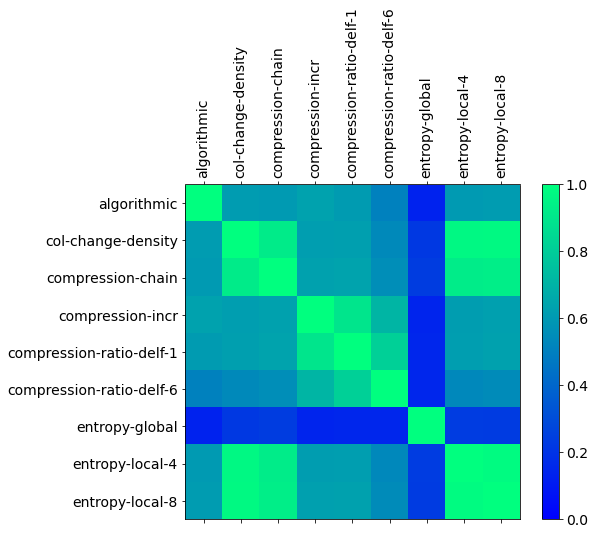

In [40]:
# TO SKIP  -- PLOT SETUP
df = pd.DataFrame.from_records(complexity)

f = plt.figure(figsize=(8, 6))
plt.matshow(df.corr(method="kendall"), fignum=f.number, vmin=0, vmax=1, cmap="winter")
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

The algorithmic and global entropy based complexities order the countries rather differently to any other measures. Both of them have a global view of a flag. The other methods basically scan the flags along lines or a couple of lines. As such, they consititue a group.

### Clustering countries

Not all of the measures correlate with each other. It would thus be difficult to pin down clusters which separate flags according to their overall complexity. To illustrate this, a plot has been created where the _x_ axis orders the coutries along their median scaled complexity and the _y_ axis positions them according to the difference between their second highest and second lowest rankings. We do not use the lowest an highest rankings to minitage the effect of the vastly different `global-entropy`.

In [41]:
# TO SKIP -- BORING
def scaler(x):
    return (x - x.min()) / (x.max() - x.min())


def get_rank_limits(x, i, j):
    """
    Gets the i-th lowest and j-th highest values from an array.
    """    
    x_sorted = np.sort(x, axis=1)
    x_low = x_sorted[:, i - 1]
    x_high = x_sorted[:, x.shape[-1] - j]
    
    return np.vstack([x_low, x_high])


def get_rank_width(x, i, j):
    """
    Gets the difference between the
    i-th lowest and j highest values from an array.
    """
    x_low, x_high = get_rank_limits(x, i, j)
    x_lim = x_high - x_low

    return x_lim

In [42]:
# TO SKIP -- BORING
df_rank = df.rank()
df_rank = df_rank.apply(lambda x: scaler(x))

cols = df_rank.columns

df_rank["median"] = df_rank[cols].quantile(q=0.5, axis=1)
df_rank["w-2-8"] = get_rank_width(df_rank[cols].values, 2, 2)

df_rank["l-1-9"] = tuple(get_rank_limits(df_rank[cols], 1, 1).T)
df_rank["l-2-8"] = tuple(get_rank_limits(df_rank[cols], 2, 2).T)
df_rank["l-3-7"] = tuple(get_rank_limits(df_rank[cols], 3, 3).T)
df_rank["l-4-6"] = tuple(get_rank_limits(df_rank[cols], 4, 4).T)

comp_rankings = df_rank.to_dict()

Text(0, 0.5, 'max - min scaled rank')

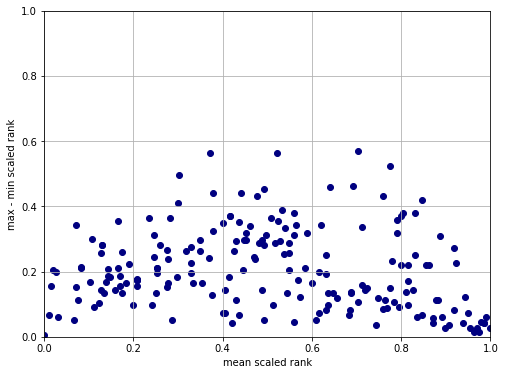

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df_rank["median"], df_rank["w-2-8"], color="navy")
ax.set_xlim((0, 1)); ax.set_ylim((0, 1)); ax.grid(True, which="both")
ax.set_xlabel("mean scaled rank"); ax.set_ylabel("max - min scaled rank")

The lower the _y_ value the closer the rankings are. Any point above _y=0.2_ means that the country's lowest an highest positions are about 40 units apart. Considering the number of countries (196) this corresponds to being  in two different quintiles. Nevertheless, two groups can be outlined roughly.
* The bottom right corner of complex flags where the points are dense meaning really complex flags are deemed as such by almost all methods.
* The bottom left corner of simple flags, which is somewhat diffuse.

Text(0, 0.5, 'scaled ranking')

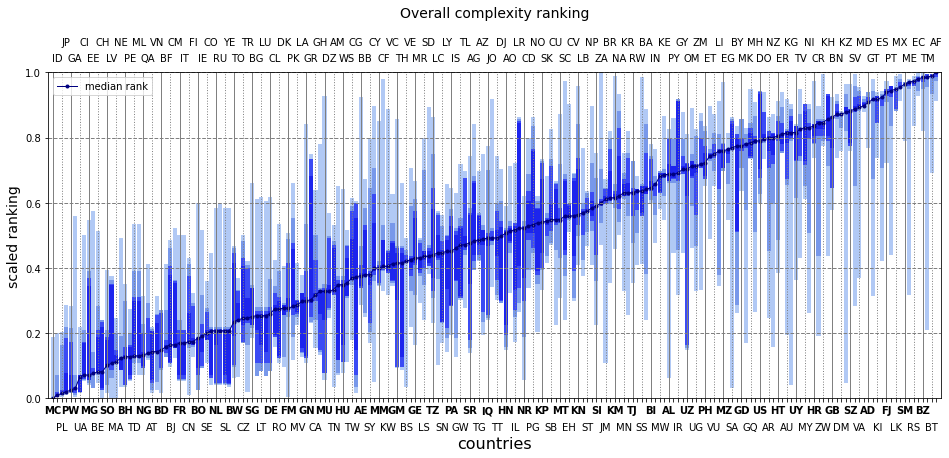

In [46]:
# TO SKIP -- PLOT SETUP
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)

plotter_comp = CountryPlotter(
    comp_rankings["median"],
    "median rank", ax,
    "Overall complexity ranking"
)
plotter_comp.plot_reference()

dts = ["l-1-9", "l-2-8", "l-4-6", "l-3-7"]
colors = ["blue", "mediumblue", "royalblue", "cornflowerblue"][::-1]
for dt, c  in zip(dts, colors):
    rectangles = []
    for i, k in enumerate(plotter_comp.ref_series["x"]):
        l, u = comp_rankings[dt][k]
        rectangles.append(Rectangle((i - 0.45, l), 0.90, u - l))
        
    pc = PatchCollection(rectangles, facecolors=c, alpha=0.5)
    ax.add_collection(pc)
    
ax.set_ylim((0, 1)); ax.set_ylabel("scaled ranking")

This becomes more obvious when the countries are plotted according to their medium rank superimposed with the successively increasing brackets of the ordered ranks per each of them _i.e_ (4, 6), (3, 7) _etc_. The high end of the plot collects countries whose minimum and maximum ranks -- the area shaded in blue -- are close. The middle of the curve sees varied scores per entry. Few countries, again, have a modest spread at the lowest medium ranks.

### What are the least complex flags?
Taking the starting eight:
* Monaco, Indonesia, Poland, Japan
* Palau, Gabon, Ukraine, Ivory Coast

### What are the most complex flags?
Taking the top twenty:
* Esatini, El Salvador, Vatican City, Moldova
* Andorra, Guetamala, Kiribati, Spain
* Fiji, Portugal, Sri Lanka, Mexico
* San Marino, Mexico, Serbia, Ecuador
* Belize, Turkmenistan, Bhutan, Afghanistan

## Not in blog

In [45]:
@nb.jit(nopython=True)
def array_segmenter(image):
    """Labels the connected components in a 2D image"""
    
    im = image + 0
    nh, nw = im.shape[:2]
    
    not_found = False
    segment_counter = 0
    next_starts = [[nh//4, nw//4]]
    
    while (im > -1).sum() != 0:
        
        # get new i, j
        for (i, j) in next_starts:
            if im[i, j] > -1:
                active = im[i, j] + 0
                queue = [[i, j]]
                not_found = False
                break
            not_found = True
            
        if not_found:
            break
            
        segment_counter -= 1
        im[i, j] = segment_counter
        
        while len(queue) != 0:
            
            i, j = queue.pop()
            
            nbs = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

            for k, l in nbs:
                if (-1 < k  < nh) and (-1 < l < nw):
                    if im[k, l] == active:
                        im[k, l] = segment_counter
                        queue.append([k, l])
                    else:
                        if im[k, l] > -1:
                            next_starts.append([k, l])
                        
    return im


def pad_image(image):
    """Adds a one pixel wide background to a 2D image"""
    
    # add borders with a new label
    n_h, n_w = image.shape
    pad_value = image.max() + 1  # hopefully, it does not overflow
    image_new = np.full((n_h + 2, n_w + 2), pad_value, dtype=image.dtype)
    image_new[1:-1, 1:-1] = image + 0
    
    return image_new

    
def get_component_borders(image):
    """Retreives the borders of the connected components"""
    
    # vertical diff
    iv_upper, ih = np.nonzero(image[:-1] - image[1:])
    # reverse border
    iv_lower = iv_upper + 1
    
    # horizontal diff
    iv, ih_left = np.nonzero(image[:, :-1] - image[:, 1:])
    # reverse border
    ih_right = ih_left + 1
    
    # rereive borders
    borders = np.hstack([
        np.vstack([image[iv_upper, ih], image[iv_lower, ih]]),
        np.vstack([image[iv, ih_left],  image[iv, ih_right]]),
        np.vstack([image[iv_lower, ih], image[iv_upper, ih]]),
        np.vstack([image[iv, ih_right], image[iv, ih_left]])
    ]).T
    
    return borders


def process_borders(borders, border_label=0):
    """Collates the borders and cleans them."""
    
    # group boders
    labels = np.unique(borders)
    border_labels = np.unique(borders, axis=0)
    
    # find true enclaves
    borders_to_remove = {}
    for label in labels:
        if (((border_labels[:, 0] == label).sum() == 1)
        and (label != border_label)):
        
            sel = border_labels[border_labels[:, 0] == label]
            n_remove = np.logical_and(
                borders[:, 0] == sel[0, 0],
                borders[:, 1] == sel[0, 1]
            ).sum()
            
            borders_to_remove.update({sel[0, 1]: n_remove})

    border_lengths = {}
    for label in labels:
        border_length = (borders[:, 0] == label).sum()

        # remove enclave
        if label in borders_to_remove:
            border_length -= borders_to_remove[label]
        
        border_lengths.update({label: border_length})
        
    # hysteresis
    border_lengths = {k: v for k, v in border_lengths.items() if v > 9}

    # remove border
    del border_lengths[border_label]

    return border_lengths


def calc_chain_code_length(border_lengths):
    """Calculates the length of a chain code from a set of borders."""
    
    item_size = 1  # in bytes
    n_item = len(border_lengths)
    n_coord = sum(border_lengths.values())
    
    # total size:
    # item_size * (no of coordinates + no of items * (colour + 2 * z_order + item sep))
    # = item_size * (nc + ni * (1 + 2 + 1)) =
    # = item_size * (nc + 4 * ni)
    
    size = item_size * (2 * n_coord + 4 * n_item)
    
    return size


def calc_chain_code_compression(image):
    """Calculates chain code compression ratio."""

    segmented = array_segmenter(image)
    padded = pad_image(segmented)
    borders = get_component_borders(padded)
    borders_processed = process_borders(borders)
    length = calc_chain_code_length(borders_processed)
    
    compression_ratio = length / image.size
    
    return compression_ratio